In [88]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import sqlite3
import geopandas as gpd 
import json

In [89]:
clean_crash_data = pd.read_csv('cleaned_crash_data.csv')

# Read in the GeoJSON files as a GeoDataFrame
geo_crash_data = gpd.read_file('cleaned_crash_data.geojson')
geo_boundary_data = gpd.read_file('Texas_County_Boundaries.geojson')

In [90]:
# Convert the GeoDataFrames to regular Pandas DataFrames
geo_crash_data = pd.DataFrame(geo_crash_data)
geo_boundary_data = pd.DataFrame(geo_boundary_data)

# Convert the geometry column to a JSON column
geo_crash_data['geometry'] = geo_crash_data['geometry'].apply(lambda x: json.dumps(x.__geo_interface__))
geo_boundary_data['geometry'] = geo_boundary_data['geometry'].apply(lambda x: json.dumps(x.__geo_interface__))

In [91]:
# SQLite database file 
engine = create_engine('sqlite:///crash_data.db')

# Store the dataframes in the database
clean_crash_data.to_sql('crashes', engine, if_exists='replace', index=False)
geo_crash_data.to_sql('geocrashes', engine, if_exists='replace', index=False)
geo_boundary_data.to_sql('geoboundaries', engine, if_exists='replace', index=False)

254

In [92]:
# Connect to  SQLite database
conn = sqlite3.connect('crash_data.db')

Queries

In [93]:
# How many people are involved in each crash?
people_per_crash = pd.read_sql_query("SELECT `Crash ID`, COUNT(*) as `Number of People Involved` FROM crashes GROUP BY `Crash ID`", conn)
people_per_crash

,Crash ID,Number of People Involved
0,18429001,3
1,18674968,1
2,18676126,3
3,18677918,3
4,18679166,1
...,...,...
1925,19366862,2
1926,19393976,5
1927,19394558,2
1928,19411341,2


In [94]:
# How many crashes are in this data set?
unique_crash_ids_count = pd.read_sql_query("SELECT COUNT(DISTINCT `Crash ID`) as unique_crash_ids FROM crashes", conn)
count = unique_crash_ids_count.iloc[0]['unique_crash_ids']
print(f"There are {count} unique Crash IDs in this data set.")

There are 1930 unique Crash IDs in this data set.


In [95]:
# How many fatalities are in this data set?
fatalities = pd.read_sql_query("SELECT COUNT(*) FROM crashes WHERE `Crash Severity` = 'K - FATAL INJURY'", conn)
fatalities 

,COUNT(*)
0,1854


In [96]:
# How many serious injuries are in this data set?
serious_injuries = pd.read_sql_query("SELECT COUNT(*) FROM crashes WHERE `Crash Severity` = 'A - SUSPECTED SERIOUS INJURY'", conn)
serious_injuries

,COUNT(*)
0,4241


In [97]:
# How many crashes involved a school bus? 
school_bus_crashes = pd.read_sql_query("SELECT DISTINCT `Crash ID` FROM crashes WHERE `School Bus Flag` = 1", conn)
school_bus_crashes.tail()

,Crash ID
27,19195596
28,19203866
29,19231488
30,19297648
31,19393976


In [98]:
# How many crashes involved a commercial vehicle? 
cmv_crashes = pd.read_sql_query("SELECT DISTINCT `Crash ID` FROM crashes WHERE `Commercial Motor Vehicle Flag` = 1", conn)
cmv_crashes.tail()

,Crash ID
1925,19318996
1926,19324110
1927,19325090
1928,19366862
1929,19415282


In [99]:
# How many crashes involved a speed limit over 55?
speed_limit_over_55_crashes = pd.read_sql_query("SELECT DISTINCT `Crash ID` FROM crashes WHERE `Speed Limit` > 55", conn)
speed_limit_over_55_crashes.tail()

,Crash ID
1269,19348989
1270,19318996
1271,19324110
1272,19366862
1273,19415282


In [100]:
# How many crashes involved a speed limit between 26 and 55?
speed_limit_26_to_55_crashes = pd.read_sql_query("SELECT DISTINCT `Crash ID` FROM crashes WHERE `Speed Limit` >= 26 AND `Speed Limit` <= 55", conn)
speed_limit_26_to_55_crashes.tail()

,Crash ID
621,19394558
622,19303087
623,19308211
624,19314322
625,19313534


In [101]:
unique_speed_limit_26_to_55_crashes = speed_limit_26_to_55_crashes.shape[0]
print(f"There are {unique_speed_limit_26_to_55_crashes} crashes involving a speed limit between 26 and 55.")

There are 626 crashes involving a speed limit between 26 and 55.


In [102]:
# How many crashes involved a speed limit equal to or under 25?
speed_limit_under_25_crashes = pd.read_sql_query("SELECT DISTINCT `Crash ID` FROM crashes WHERE `Speed Limit` <= 25", conn)
speed_limit_under_25_crashes.tail()

,Crash ID
25,19197546
26,19234524
27,19281523
28,19277183
29,19325090


In [103]:
# How many crashes happened on Saturdays and Sundays?
weekend_crashes = pd.read_sql_query("SELECT DISTINCT `Crash ID` FROM crashes WHERE `Day of Week` IN ('SATURDAY', 'SUNDAY')", conn)
weekend_crashes.tail()

,Crash ID
335,19347792
336,19324110
337,19325090
338,19366862
339,19415282


In [104]:
# People involved in week day crashes: 
weekday_crashes = pd.read_sql_query("SELECT * FROM crashes WHERE `Day of Week` NOT IN ('SATURDAY', 'SUNDAY')", conn)
weekday_crashes.tail()

,Unnamed: 0,Crash ID,City,Commercial Motor Vehicle Flag,County,Crash Date,Crash Severity,Crash Time,Day of Week,Latitude,...,Speed Limit,CMV Vehicle Type,Contributing Factor 1,Possible Vehicle Defect 1,Vehicle Defect 1,Person Age,Person Gender,Person Injury Severity,Person Restraint Used,Person Type
4903,6081,19348989,OUTSIDE CITY LIMITS,1,MIDLAND,2022-12-29,K - FATAL INJURY,18:31,THURSDAY,31.965720,...,75,6 - SINGLE UNIT TRUCK 3 OR MORE AXLES,37 - FAILED TO YIELD RIGHT OF WAY - TURNING LEFT,No Vehicle Defect,No Vehicle Defect,52.0,1 - MALE,N - NOT INJURED,1 - SHOULDER & LAP BELT,1 - DRIVER
4904,6082,19348989,OUTSIDE CITY LIMITS,1,MIDLAND,2022-12-29,K - FATAL INJURY,18:31,THURSDAY,31.965720,...,75,Not CMV,No Contributing Factor,No Vehicle Defect,No Vehicle Defect,41.0,1 - MALE,K - FATAL INJURY,96 - NONE,1 - DRIVER
4905,6083,19318996,OUTSIDE CITY LIMITS,1,ERATH,2022-12-30,A - SUSPECTED SERIOUS INJURY,11:47,FRIDAY,32.069332,...,75,6 - SINGLE UNIT TRUCK 3 OR MORE AXLES,No Contributing Factor,No Vehicle Defect,No Vehicle Defect,74.0,1 - MALE,N - NOT INJURED,1 - SHOULDER & LAP BELT,1 - DRIVER
4906,6084,19318996,OUTSIDE CITY LIMITS,1,ERATH,2022-12-30,A - SUSPECTED SERIOUS INJURY,11:47,FRIDAY,32.069332,...,75,Not CMV,22 - FAILED TO CONTROL SPEED,No Vehicle Defect,No Vehicle Defect,29.0,1 - MALE,A - SUSPECTED SERIOUS INJURY,1 - SHOULDER & LAP BELT,1 - DRIVER
4907,6085,19318996,OUTSIDE CITY LIMITS,1,ERATH,2022-12-30,A - SUSPECTED SERIOUS INJURY,11:47,FRIDAY,32.069332,...,75,Not CMV,22 - FAILED TO CONTROL SPEED,No Vehicle Defect,No Vehicle Defect,26.0,2 - FEMALE,N - NOT INJURED,1 - SHOULDER & LAP BELT,2 - PASSENGER/OCCUPANT


Visualizations

In [105]:
driver_gender = pd.read_sql_query("SELECT DISTINCT `Crash ID`, `Person Gender` FROM crashes WHERE `Person Type` = '1 - DRIVER'", conn)

gender_counts = driver_gender.groupby('Person Gender').count()

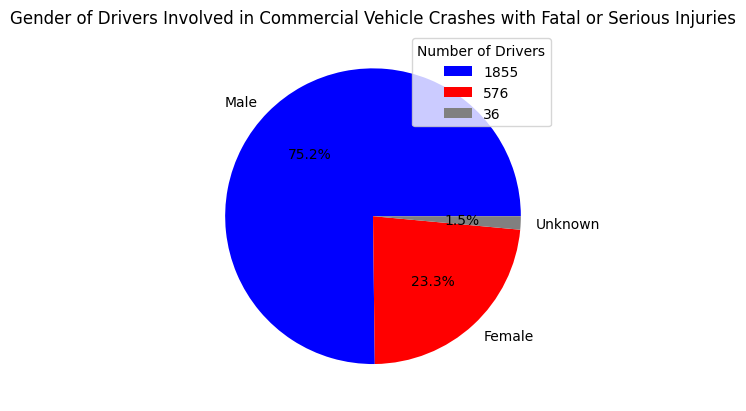

In [106]:
# Pie Chart
labels=['Male', 'Female', 'Unknown']
colors = ['blue', 'red', 'grey']
sizes = gender_counts['Crash ID']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title('Gender of Drivers Involved in Commercial Vehicle Crashes with Fatal or Serious Injuries')
plt.legend(title='Number of Drivers', loc='upper right', labels=sizes)
plt.show()

In [107]:
# Bin age groups
age_bins = [0, 15, 19, 24, 34, 44, 54, 64, 74, 84, 94, 150]
age_labels = ['<16', '16-19', '20-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84', '85-94', '>=95']

# Get data for serious injuries and fatal injuries by age group
serious_injuries = pd.read_sql_query("SELECT DISTINCT `Crash ID`, `Person Age`, `Person Injury Severity` FROM crashes WHERE `Person Injury Severity` = 'A - SUSPECTED SERIOUS INJURY' AND `Person Type` = '1 - DRIVER'", conn)
fatal_injuries = pd.read_sql_query("SELECT DISTINCT `Crash ID`, `Person Age`, `Person Injury Severity` FROM crashes WHERE `Person Injury Severity` = 'K - FATAL INJURY' AND `Person Type` = '1 - DRIVER'", conn)

# Bin age groups for both injury types
serious_injuries['Age Group'] = pd.cut(serious_injuries['Person Age'], bins=age_bins, labels=age_labels, include_lowest=True)
fatal_injuries['Age Group'] = pd.cut(fatal_injuries['Person Age'], bins=age_bins, labels=age_labels, include_lowest=True)

# Get counts for each age group for both injury types
serious_injury_counts = serious_injuries['Age Group'].value_counts().sort_index()
fatal_injury_counts = fatal_injuries['Age Group'].value_counts().sort_index()

# Combine counts with concat
combined_counts = pd.concat([serious_injury_counts, fatal_injury_counts], axis=1)
combined_counts.columns = ['Serious Injury', 'Fatal Injury']

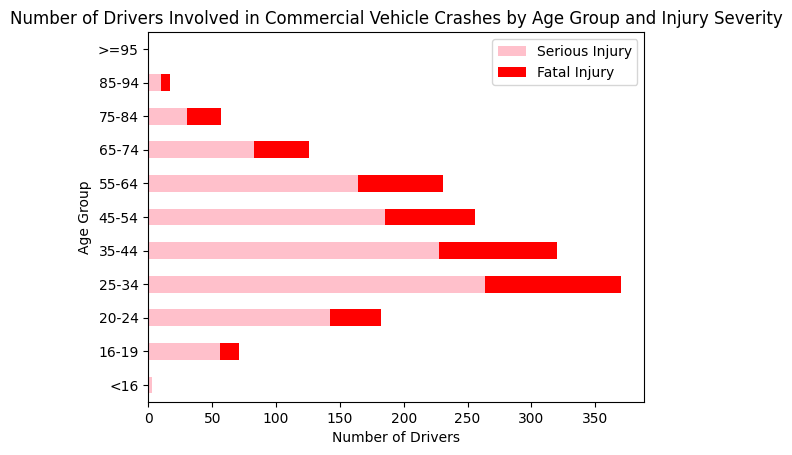

In [108]:
# Stacked Horizontal Bar Graph for Age and Injury
combined_counts.plot(kind='barh', stacked=True, color=['pink', 'red'])
plt.xlabel('Number of Drivers')
plt.ylabel('Age Group')
plt.title('Number of Drivers Involved in Commercial Vehicle Crashes by Age Group and Injury Severity')
plt.show()

In [109]:
# Get data for serious injuries and fatal injuries by restraint type
restraint_fatal_injuries = pd.read_sql_query("SELECT `Crash ID`, `Person Restraint Used`, `Person Injury Severity` FROM crashes WHERE `Person Injury Severity` = 'K - FATAL INJURY'", conn)
restraint_serious_injuries = pd.read_sql_query("SELECT `Crash ID`, `Person Restraint Used`, `Person Injury Severity` FROM crashes WHERE `Person Injury Severity` = 'A - SUSPECTED SERIOUS INJURY'", conn)
restraint_minor_injuries = pd.read_sql_query("SELECT `Crash ID`, `Person Restraint Used`, `Person Injury Severity` FROM crashes WHERE `Person Injury Severity` = 'B - SUSPECTED MINOR INJURY'", conn)
restraint_possible_injuries = pd.read_sql_query("SELECT `Crash ID`, `Person Restraint Used`, `Person Injury Severity` FROM crashes WHERE `Person Injury Severity` = 'C - POSSIBLE INJURY'", conn)
restraint_no_injuries = pd.read_sql_query("SELECT `Crash ID`, `Person Restraint Used`, `Person Injury Severity` FROM crashes WHERE `Person Injury Severity` = 'N - NOT INJURED'", conn)

# Get counts for each restraint type for both injury types
restraint_fatal_injury_counts = restraint_fatal_injuries['Person Restraint Used'].value_counts().sort_index()
restraint_serious_injury_counts = restraint_serious_injuries['Person Restraint Used'].value_counts().sort_index()
restraint_minor_injury_counts = restraint_minor_injuries['Person Restraint Used'].value_counts().sort_index()
restraint_possible_injury_counts = restraint_possible_injuries['Person Restraint Used'].value_counts().sort_index()
restraint_no_injury_counts = restraint_no_injuries['Person Restraint Used'].value_counts().sort_index()


# Combine counts with concat
restraint_combined_counts = pd.concat([restraint_fatal_injury_counts, restraint_serious_injury_counts, restraint_minor_injury_counts, restraint_possible_injury_counts, restraint_no_injury_counts], axis=1)
restraint_combined_counts.columns = ['Fatal Injury', 'Serious Injury', 'Minor Injury', 'Possible Injury', 'No Injury']

In [110]:
restraint_serious_injuries

,Crash ID,Person Restraint Used,Person Injury Severity
0,18674968,1 - SHOULDER & LAP BELT,A - SUSPECTED SERIOUS INJURY
1,18676126,97 - NOT APPLICABLE,A - SUSPECTED SERIOUS INJURY
2,18679166,96 - NONE,A - SUSPECTED SERIOUS INJURY
3,18680919,98 - OTHER (EXPLAIN IN NARRATIVE),A - SUSPECTED SERIOUS INJURY
4,18684709,1 - SHOULDER & LAP BELT,A - SUSPECTED SERIOUS INJURY
...,...,...,...
1658,19318996,1 - SHOULDER & LAP BELT,A - SUSPECTED SERIOUS INJURY
1659,19324110,96 - NONE,A - SUSPECTED SERIOUS INJURY
1660,19324110,96 - NONE,A - SUSPECTED SERIOUS INJURY
1661,19325090,97 - NOT APPLICABLE,A - SUSPECTED SERIOUS INJURY


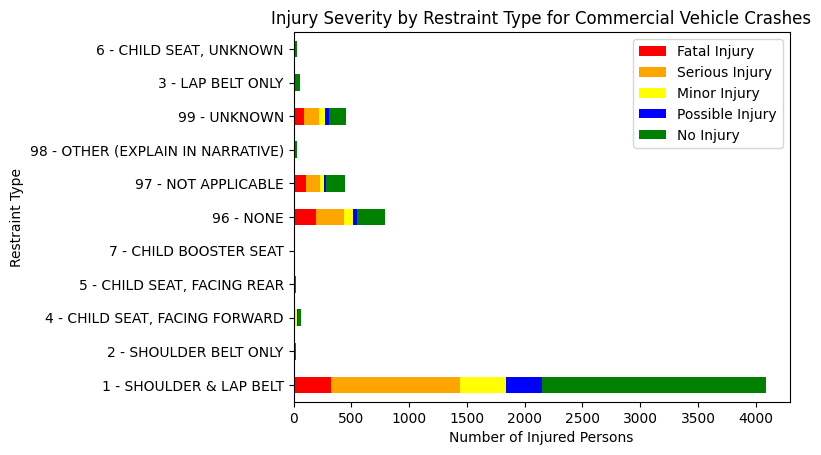

In [111]:
restraint_combined_counts.plot(kind='barh', stacked=True, color=['red', 'orange', 'yellow', 'blue', 'green'])
plt.xlabel('Number of Injured Persons')
plt.ylabel('Restraint Type')
plt.title('Injury Severity by Restraint Type for Commercial Vehicle Crashes')
plt.show()



In [112]:
contributing_factors = pd.read_sql_query("SELECT `Contributing Factor 1` FROM crashes", conn)

top_contributing_factors = contributing_factors.value_counts().head(11)

top_contributing_factors

Contributing Factor 1                            
No Contributing Factor                               2995
22 - FAILED TO CONTROL SPEED                          599
98 - OTHER (EXPLAIN IN NARRATIVE)                     330
23 - FAILED TO DRIVE IN SINGLE LANE                   268
35 - FAILED TO YIELD RIGHT OF WAY - STOP SIGN         246
60 - UNSAFE SPEED                                     167
20 - DRIVER INATTENTION                               117
34 - FAILED TO YIELD RIGHT OF WAY - PRIVATE DRIVE      97
15 - DISREGARD STOP AND GO SIGNAL                      88
70 - WRONG SIDE - NOT PASSING                          84
4 - CHANGED LANE WHEN UNSAFE                           81
dtype: int64

In [113]:
speed_limit_counts = pd.read_sql_query("SELECT `Speed Limit`, COUNT(DISTINCT `Crash ID`) as Crash_Count FROM crashes GROUP BY `Speed Limit`", conn)

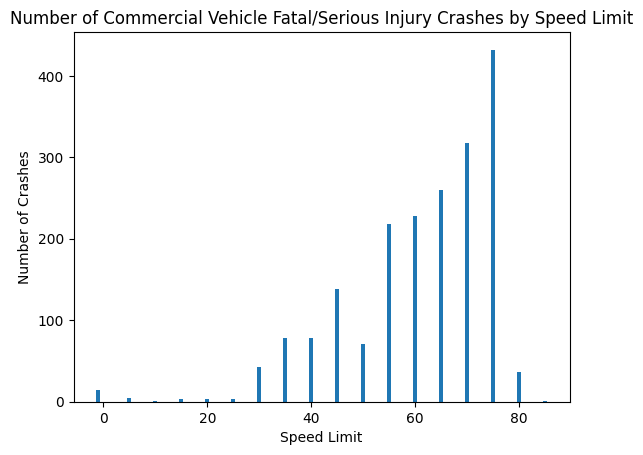

In [114]:
plt.bar(speed_limit_counts['Speed Limit'], speed_limit_counts['Crash_Count'])
plt.xlabel('Speed Limit')
plt.ylabel('Number of Crashes')
plt.title('Number of Commercial Vehicle Fatal/Serious Injury Crashes by Speed Limit')
plt.show()

In [115]:
# Read the data from the 'crashes' table
crash_data = pd.read_sql_query("SELECT * FROM crashes", conn)

# Extract the hour from the Crash Time column
crash_data['Hour'] = crash_data['Crash Time'].apply(lambda x: int(x.split(':')[0]))

# Group the data by 'Day of Week' and 'Hour', and count the number of distinct Crash IDs
grouped_data = crash_data.groupby(['Day of Week', 'Hour'])['Crash ID'].nunique().reset_index(name='Crash_Count')

# Pivot the data to create a DataFrame with 'Hour' as the index, and each day of the week as a separate column
pivoted_data = grouped_data.pivot_table(index='Hour', columns='Day of Week', values='Crash_Count', fill_value=0)

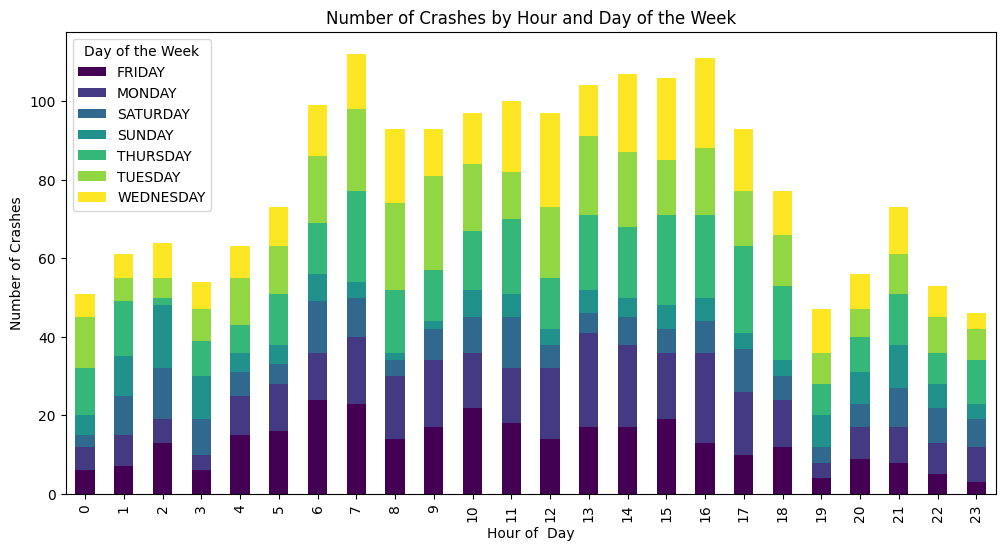

In [116]:
# Stacked bar graph for Day and Time
ax = pivoted_data.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
ax.set_xlabel('Hour of  Day')
ax.set_ylabel('Number of Crashes')
ax.set_title('Number of Crashes by Hour and Day of the Week')
plt.xticks(range(0, 24), range(0, 24))
plt.legend(title='Day of the Week')
plt.show()

In [117]:
# Close connection
conn.close()